In [105]:
import sys
sys.path.append('../')

In [106]:
import pennylane as qml 
from pennylane import numpy as np 
import matplotlib.pyplot as plt 
from main import VarFourier, QFT 

In [107]:
num_qubits = 5

In [108]:
state1 = np.random.randn(8)
state1 = state1 / np.linalg.norm( state1 )

state2 = np.random.randn(4)
state2 = state2 / np.linalg.norm( state2 )

(<Figure size 900x600 with 1 Axes>, <Axes: >)

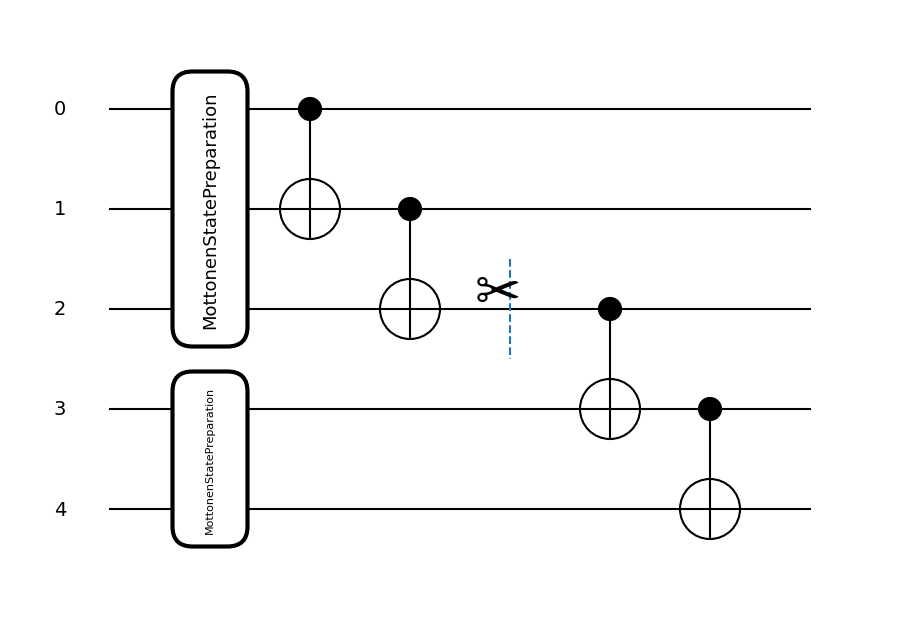

In [303]:
def var_state(params=None):    
    # qml.RX(5*np.pi/6,0)
    # qml.Hadamard(0)
    qml.MottonenStatePreparation( state1, range(3))
    qml.MottonenStatePreparation( state2, range(3,5))

    for j in range(num_qubits-1):
        qml.CNOT([j,j+1])
        # qml.Hadamard(j+1)
        if j==1:
            qml.WireCut(wires=j+1)

qml.draw_mpl( var_state )()   

(<Figure size 1100x675 with 1 Axes>, <Axes: >)

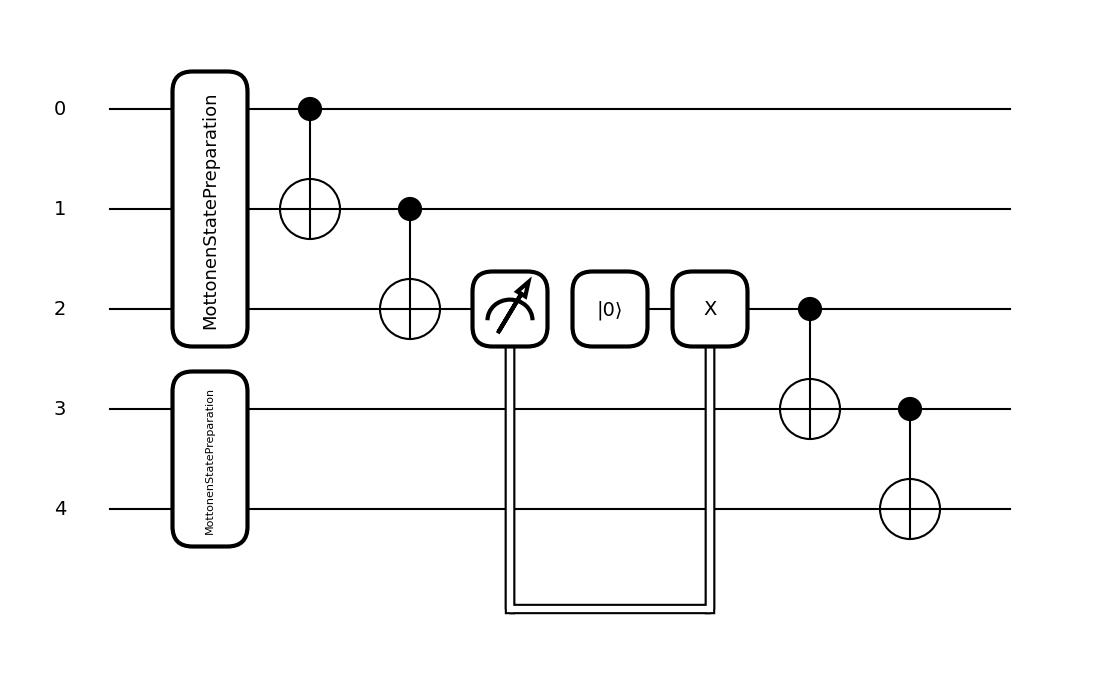

In [545]:
def var_state_cut_x(params=None, mz=[]):
    # qml.RX(5*np.pi/6,0)
    # qml.Hadamard(0)
    qml.MottonenStatePreparation( state1, range(3))
    qml.MottonenStatePreparation( state2, range(3,5))
    for j in range(num_qubits-1):
        qml.CNOT([j,j+1])
        # qml.Hadamard(j+1)
        if j==1:
            qml.Hadamard(j+1)
            m = qml.measure(wires=j+1, reset=True)
            qml.cond(m==1, qml.PauliX )(j+1)
            qml.Hadamard(j+1)
            mz.append(m)


def var_state_cut_y(params=None, mz=[]):
    # qml.RX(5*np.pi/6,0)
    # qml.Hadamard(0)
    qml.MottonenStatePreparation( state1, range(3))
    qml.MottonenStatePreparation( state2, range(3,5))
    for j in range(num_qubits-1):
        qml.CNOT([j,j+1])
        # qml.Hadamard(j+1)
        if j==1:
            qml.PauliZ(j+1)
            qml.S(j+1)
            qml.Hadamard(j+1)
            m = qml.measure(wires=j+1, reset=True)
            qml.cond(m==1, qml.PauliX )(j+1)
            qml.Hadamard(j+1)
            qml.S(j+1)
            mz.append(m)

def var_state_cut_z(params=None, mz=[]):
    # qml.RX(5*np.pi/6,0)
    # qml.Hadamard(0)
    qml.MottonenStatePreparation( state1, range(3))
    qml.MottonenStatePreparation( state2, range(3,5))
    for j in range(num_qubits-1):
        qml.CNOT([j,j+1])
        # qml.Hadamard(j+1)
        if j==1:
            m = qml.measure(wires=j+1, reset=True)
            qml.cond(m==1, qml.PauliX )(j+1)
            mz.append(m)

qml.draw_mpl( var_state_cut_z )()   

In [305]:
dev = qml.device( "default.qubit", 
                    wires=num_qubits)

varqft = VarFourier( num_qubits,
                    lambda x : x**2/2,
                    lambda p : p**2/2,
                    dev,
                    semi_classical=False, 
                    var_state= var_state
                    )

In [306]:
qn = varqft.X_eval()

In [307]:
obs = qml.Hermitian( np.diag(varqft.fun_x_values),
                        wires = range(num_qubits) )
H = qml.Hamiltonian((1., ), (obs, )) 
obs 

Hermitian(tensor([[12.5       ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , 10.93912591,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  9.48231009, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  9.48231009,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         10.93912591,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , 12.5       ]], requires_grad=True), wires=[0, 1, 2, 3, 4])

In [391]:
@qml.qnode(dev)
def fun():
    var_state()       
    QFT( num_qubits, True )     
    obs = qml.Hermitian( np.diag(varqft.fun_x_values),
                        wires = range(num_qubits) )
    H = qml.Hamiltonian((1., ), (obs, ))      
    return qml.expval(H)  

@qml.qnode(dev)
def fun_x():
    mz = []
    var_state_cut_x( mz=mz)       
    QFT( num_qubits, False )     
    obs = qml.Hermitian( np.diag(varqft.fun_x_values),
                        wires = range(num_qubits) )
    H = qml.Hamiltonian((1., ), (obs, ))      
    return qml.expval(mz[0]), qml.expval(H)   

@qml.qnode(dev)
def fun_y():
    mz = []
    var_state_cut_y( mz=mz)       
    QFT( num_qubits, False )     
    obs = qml.Hermitian( np.diag(varqft.fun_x_values),
                        wires = range(num_qubits) )
    H = qml.Hamiltonian((1., ), (obs, ))      
    return qml.expval(mz[0]), qml.expval(H)   

@qml.qnode(dev)
def fun_z():
    mz = []
    var_state_cut_z( mz=mz)       
    QFT( num_qubits, False )     
    obs = qml.Hermitian( np.diag(varqft.fun_x_values),
                        wires = range(num_qubits) )
    H = qml.Hamiltonian((1., ), (obs, ))      
    return qml.expval(mz[0]), qml.expval(H)   

In [392]:
fun()

ValueError: ops operation Hadamard(wires=[0]) must occur prior to measurements. Please place earlier in the queue.

In [390]:
sx, Ex = fun_x()
sy, Ey = fun_y()
sz, Ez = fun_z()

s0 = 1
sx = 1-2*sx
sy = 1-2*sy
sz = 1-2*sz

s0, sx, sy, sz, Ex, Ey, Ez 

(1,
 tensor(0.13702545, requires_grad=True),
 tensor(1.55431223e-15, requires_grad=True),
 tensor(-0.45670284, requires_grad=True),
 tensor(4.5112311, requires_grad=True),
 tensor(4.39836846, requires_grad=True),
 tensor(4.43732226, requires_grad=True))

In [326]:
( Ez/s0 + Ex/sx + Ez/sz )/8

tensor(3.45548828, requires_grad=True)

In [327]:
( Ez + Ex + Ey + Ez ) / 4

tensor(4.44606102, requires_grad=True)

In [423]:
# @qml.qnode(dev)
def var_state(params=None):    
    # qml.RX(5*np.pi/6,0)
    qml.Hadamard(0)
    # qml.MottonenStatePreparation( state1, range(3))
    # qml.MottonenStatePreparation( state2, range(3,5))

    for j in range(num_qubits-1):
        qml.CNOT([j,j+1])
        # qml.Hadamard(j+1)
        if j==0:
            qml.WireCut(wires=j+1)
    # return qml.expval(H)

var_state()

In [463]:
def Outer2Kron( A, Dims ):
    # From vec(A) outer vec(B) to A kron B
    N   = len(Dims)
    Dim = A.shape
    A   = np.transpose( A.reshape(2*Dims), np.array([range(N),range(N,2*N) ]).T.flatten() ).flatten()
    return A.reshape(Dim)

def LocalProduct( Psi, Operators , Dims=[] ):
    """
    Calculate the product (A1xA2x...xAn)|psi>
    """
    sz = Psi
    if not Dims: 
        Dims = [ Operators[k].shape[-1] for k in range( len(Operators) ) ]
    N = len(Dims)
    for k in range(N):
        Psi  = (( Operators[k]@Psi.reshape(Dims[k],-1) ).T ).flatten()
    return Psi

def InnerProductMatrices( X, B, Vectorized = False ):
    """
    Calculate the inner product tr( X [B1xB2x...xBn])
    """
    X = np.array(X)
    
    if isinstance(B, list): 
        B = B.copy()
        nsys = len(B)
        nops = []
        Dims = []
        if Vectorized == False :
            for j in range(nsys):
                B[j] = np.array(B[j])
                if B[j].ndim == 2 :
                    B[j] = np.array([B[j]])
                nops.append( B[j].shape[0] )
                Dims.append( B[j].shape[1] )
                B[j] = B[j].reshape(nops[j],Dims[j]**2)
        elif Vectorized == True :
            for j in range(nsys):
                nops.append( B[j].shape[0] )
                Dims.append( int(np.sqrt(B[j].shape[1])) )                
        
        if X.ndim == 2 :       
            TrXB = LocalProduct( Outer2Kron( X.flatten(), Dims ), B ) 
        elif X.ndim == 3 :
            TrXB = []
            for j in range( X.shape[0] ):
                TrXB.append( LocalProduct( Outer2Kron( X[j].flatten(), Dims ), B ) )
        elif X.ndim == 1:
            TrXB = LocalProduct( Outer2Kron( X, Dims ), B ) 
        
        return np.array( TrXB ).reshape(nops)
        
    elif isinstance(B, np.ndarray):     
        
        if B.ndim == 2 and Vectorized == False :
            return np.trace( X @ B )
        
        elif B.ndim == 4 :
            nsys = B.shape[0]
            nops = nsys*[ B[0].shape[0] ]
            Dims = nsys*[ B[0].shape[1] ]
            B = B.reshape(nsys,nops[0],Dims[0]**2)
            
        elif B.ndim == 3 :
            if Vectorized == False :
                nsys = 1
                nops = B.shape[0]       
                Dims = [ B.shape[1] ]
                B = B.reshape(nsys,nops,Dims[0]**2)
            if Vectorized == True :
                nsys = B.shape[0]
                nops = nsys*[ B[0].shape[0] ]
                Dims = nsys*[ int(np.sqrt(B[0].shape[1])) ]
        if X.ndim == 2 :       
            TrXB = LocalProduct( Outer2Kron( X.flatten(), Dims ), B ) 
        elif X.ndim == 3 :
            TrXB = []
            for j in range( X.shape[0] ):
                TrXB.append( LocalProduct( Outer2Kron( X[j].flatten(), Dims ), B ) )
        elif X.ndim == 1:
            TrXB = LocalProduct( Outer2Kron( X, Dims ), B ) 

        return np.array( TrXB ).reshape(nops)

In [508]:
I = np.eye(2)
Z = np.array([1,0,0,-1]).reshape(2,2)

components = InnerProductMatrices( np.diag(varqft.fun_x_values), num_qubits*[ [I, Z] ] ).reshape(-1)

In [509]:
from itertools import product
iter_labels = product(['I','Z'], repeat=num_qubits)

coeffs = []
obs  = []
Hamils = []
for j, label in enumerate( iter_labels ):
    component_j = components[j]
    if not np.isclose( component_j, 0 ):
        op_label = qml.pauli.string_to_pauli_word(''.join( label ) )
        coeffs.append( component_j )
        obs.append( op_label )
        Hamils.append( qml.Hamiltonian( (component_j,), (op_label,) ) )
        print( component_j, ''.join( label ) )
Hamils

141.93548387096774 IIIII
1.6649323621227836 IIIZZ
3.329864724245585 IIZIZ
6.659729448491166 IIZZI
6.659729448491156 IZIIZ
13.319458896982315 IZIZI
26.638917793964616 IZZII
13.319458896982313 ZIIIZ
26.638917793964623 ZIIZI
53.277835587929246 ZIZII
106.55567117585848 ZZIII


[<Hamiltonian: terms=1, wires=[0]>,
 <Hamiltonian: terms=1, wires=[3, 4]>,
 <Hamiltonian: terms=1, wires=[2, 4]>,
 <Hamiltonian: terms=1, wires=[2, 3]>,
 <Hamiltonian: terms=1, wires=[1, 4]>,
 <Hamiltonian: terms=1, wires=[1, 3]>,
 <Hamiltonian: terms=1, wires=[1, 2]>,
 <Hamiltonian: terms=1, wires=[0, 4]>,
 <Hamiltonian: terms=1, wires=[0, 3]>,
 <Hamiltonian: terms=1, wires=[0, 2]>,
 <Hamiltonian: terms=1, wires=[0, 1]>]

In [537]:
obs

[Identity(wires=[0]),
 PauliZ(wires=[3]) @ PauliZ(wires=[4]),
 PauliZ(wires=[2]) @ PauliZ(wires=[4]),
 PauliZ(wires=[2]) @ PauliZ(wires=[3]),
 PauliZ(wires=[1]) @ PauliZ(wires=[4]),
 PauliZ(wires=[1]) @ PauliZ(wires=[3]),
 PauliZ(wires=[1]) @ PauliZ(wires=[2]),
 PauliZ(wires=[0]) @ PauliZ(wires=[4]),
 PauliZ(wires=[0]) @ PauliZ(wires=[3]),
 PauliZ(wires=[0]) @ PauliZ(wires=[2]),
 PauliZ(wires=[0]) @ PauliZ(wires=[1])]

In [510]:
H = qml.Hamiltonian(coeffs, obs, grouping_type='qwc')
print( H )

  (141.93548387096774) [I0]
+ (1.6649323621227836) [Z3 Z4]
+ (3.329864724245585) [Z2 Z4]
+ (6.659729448491156) [Z1 Z4]
+ (6.659729448491166) [Z2 Z3]
+ (13.319458896982313) [Z0 Z4]
+ (13.319458896982315) [Z1 Z3]
+ (26.638917793964616) [Z1 Z2]
+ (26.638917793964623) [Z0 Z3]
+ (53.277835587929246) [Z0 Z2]
+ (106.55567117585848) [Z0 Z1]


In [541]:
@qml.qnode(dev)
def fun():
    var_state()       
    # QFT( num_qubits, True )   
    return qml.expval(obs[-1]) 

    

(<Figure size 900x600 with 1 Axes>, <Axes: >)

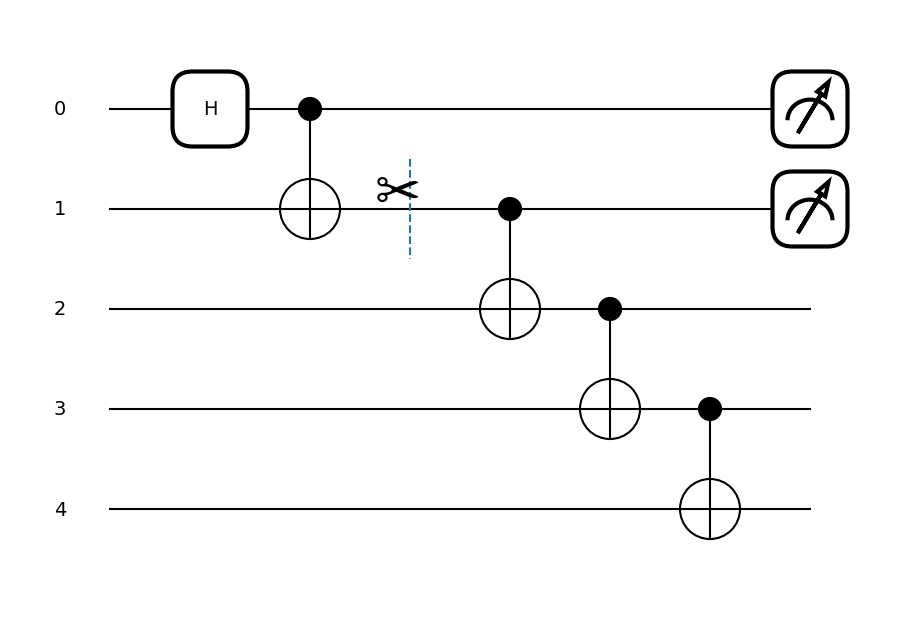

In [542]:
qml.draw_mpl(fun)()

In [543]:
fun()

tensor(1., requires_grad=True)

In [544]:
cut_tape = fun.tape
print(cut_tape.draw())

cut_graph = qml.qcut.tape_to_graph(cut_tape)
qml.qcut.replace_wire_cut_nodes(cut_graph)
fragments, communication_graph = qml.qcut.fragment_graph(cut_graph) 
fragment_tapes = [qml.qcut.graph_to_tape(f) for f in fragments]

fragment_tapes = [qml.map_wires(t, dict(zip(t.wires, dev.wires)))[0][0] for t in fragment_tapes]
expanded = [qml.qcut.expand_fragment_tape(t) for t in fragment_tapes]

configurations = []
prepare_nodes = []
measure_nodes = []
for tapes, p, m in expanded:
    configurations.append(tapes)
    prepare_nodes.append(p)
    measure_nodes.append(m)

tapes = tuple(tape for c in configurations for tape in c)

for t in tapes:
    print('----------------')
    print(qml.drawer.tape_text(t))

results = qml.execute(tapes, dev, gradient_fn=None)

qml.qcut.qcut_processing_fn(
    results,
    communication_graph,
    prepare_nodes,
    measure_nodes,) 

0: ──H─╭●──────────────┤ ╭<Z@Z>
1: ────╰X──//─╭●───────┤ ╰<Z@Z>
2: ───────────╰X─╭●────┤       
3: ──────────────╰X─╭●─┤       
4: ─────────────────╰X─┤       
----------------
0: ──H─╭●─┤ ╭<Z@I> ╭<Z@Z>
1: ────╰X─┤ ╰<Z@I> ╰<Z@Z>
----------------
0: ──H─╭●─┤ ╭<Z@X>
1: ────╰X─┤ ╰<Z@X>
----------------
0: ──H─╭●─┤ ╭<Z@Y>
1: ────╰X─┤ ╰<Z@Y>
----------------
0: ──I─╭●───────┤  <Z>
1: ────╰X─╭●────┤     
2: ───────╰X─╭●─┤     
3: ──────────╰X─┤     
----------------
0: ──X─╭●───────┤  <Z>
1: ────╰X─╭●────┤     
2: ───────╰X─╭●─┤     
3: ──────────╰X─┤     
----------------
0: ──H─╭●───────┤  <Z>
1: ────╰X─╭●────┤     
2: ───────╰X─╭●─┤     
3: ──────────╰X─┤     
----------------
0: ──H──S─╭●───────┤  <Z>
1: ───────╰X─╭●────┤     
2: ──────────╰X─╭●─┤     
3: ─────────────╰X─┤     


1.0